# **Retention Time Model Training (XGBRegressor)**

Code for training XGBRegressor for Retention Time inference

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os,sys
import joblib
import pandas as pd
import random
import time
import scipy.stats as stats
from collections import Counter

from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from IPython.display import display, clear_output
from tqdm import tqdm
import ipywidgets as widgets

sys.path.append('./tools/')
from tools import tools

rTools=tools()



In [2]:
#File path definitions
figuresPath="./modelsAssessment/retentionTime/figures"
modelEvalPath="./modelsAssessment/retentionTime"
MLModelsPath="./models/retentionTime"
trainingDataFile="./dataSets/retentionTime/RT_M67vDIA_trainingData_vd.pkl"


# **Data preprocessing**

In [3]:
# Loading of training data
data = joblib.load(trainingDataFile)
print(data["description"])
training_data=pd.concat([data['features'],data['target']], axis=1)
training_data



  Retention times under the following chromatographic gradient:
    
  time / min 	  %A   %B (MeOH) flow / mL.min^{-1} 	temperature / oC
 	-1.0 	100.0 	  0.0 	 	0.3 			30.0
 	 1.0 	100.0 	  0.0 	 	0.3 			30.0
 	 2.0 	 60.0 	 40.0 	 	0.3 			30.0
 	 6.0 	 30.0 	 70.0 	 	0.3 			30.0
 	13.0 	  0.0 	100.0 	 	0.3 			30.0
 	15.0 	  0.0 	100.0 	 	0.3 			30.0
 	15.1 	100.0 	  0.0 	 	0.3 			30.0
 	17.0 	100.0 	  0.0 	 	0.3 			30.0

    ================================   ==============
    Number of instances: 	 	591
    Instances info: 	 		591x3
    Features dimensionality: 	 	591x217
    Features (Molecular descriptors): 	real, integers
    Target (Retention time): 		real
    ================================   ==============

    Keys
    -------
        features : dataframe (591, 217)
        target: dataframe (591,1)
        feature_names: dataset column names.
        target_name: target variable name.
        instances_info: dataframe (591, 3) 
            Compound name, SMILES, and ion t

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_unbrch_alkane,fr_urea,MID_N,MID_O,MID_H,MID_X,apol,bpol,LogS,tR
0,11.799684,11.799684,0.298750,-0.702503,0.809002,10.687500,256.132,245.044,255.021769,84,...,0,0,1.958360,1.764103,7.240585,3.518122,33.636723,13.493277,-4.085698,6.956
1,11.683982,11.683982,0.242803,-0.243241,0.787268,11.375000,236.702,223.598,236.071641,84,...,0,1,4.080092,1.755851,7.594280,1.758337,33.890309,16.699691,-2.657603,6.277
2,12.459903,12.459903,0.003848,-0.437868,0.453578,29.090909,300.398,276.206,300.172545,118,...,0,0,0.000000,5.565769,5.565769,0.000000,50.139032,27.548968,-3.446334,8.273
3,12.243448,12.243448,0.062819,-0.516986,0.334306,25.173913,318.373,296.197,318.157957,124,...,0,1,4.378137,7.328871,11.707008,0.000000,48.467446,29.830554,-1.719092,7.090
4,13.616011,13.616011,0.112135,-0.818986,0.588722,11.250000,349.745,336.641,349.051714,124,...,0,0,2.024411,7.783294,13.338430,3.530726,44.103309,21.880691,-4.583445,7.564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,11.564078,11.564078,0.529031,0.529031,0.412358,9.600000,198.225,188.145,198.079313,74,...,0,0,4.162986,1.779200,5.942187,0.000000,29.709930,11.470070,-3.556546,5.576
587,11.720124,11.720124,0.270669,0.270669,0.476945,10.882353,247.645,241.597,247.026087,84,...,0,0,10.488982,1.789145,14.049128,1.771001,29.182758,11.957242,-2.428923,6.780
588,3.303889,3.303889,1.119167,1.119167,0.725803,9.538462,169.227,158.139,169.089149,64,...,0,0,2.054082,0.000000,2.054082,0.000000,28.474723,11.605277,-3.445545,7.334
589,4.443796,4.443796,0.840231,0.840231,0.657283,10.857143,201.254,194.198,201.036068,68,...,0,0,6.170176,0.000000,8.167156,0.000000,27.567551,12.332449,-3.421658,4.623


# Preliminary Cleaning

In [4]:
exploring_data=training_data.copy()
exploring_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Columns: 218 entries, MaxAbsEStateIndex to tR
dtypes: float64(112), int64(106)
memory usage: 1006.7 KB


In [5]:
#Remove duplicate and null features
exploring_data_T_summary=exploring_data.describe().T
zero_vals=list(dict.fromkeys(list(exploring_data_T_summary[exploring_data_T_summary['count']==0].index)
+list(exploring_data_T_summary[exploring_data_T_summary['max']==0.0 ].index)
+list(exploring_data_T_summary[list(exploring_data_T_summary.duplicated(['mean','std','min','max']))].index)
    ))
exploring_data=exploring_data.drop(zero_vals,axis=1)
exploring_data.drop(columns=["tR"]).columns.to_frame().to_csv(os.path.join(MLModelsPath,"RT_molecularDescriptors.vd.tsv"),sep="\t",index=False)
exploring_data

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_unbrch_alkane,fr_urea,MID_N,MID_O,MID_H,MID_X,apol,bpol,LogS,tR
0,11.799684,0.298750,-0.702503,0.809002,10.687500,256.132,245.044,255.021769,84,0.252049,...,0,0,1.958360,1.764103,7.240585,3.518122,33.636723,13.493277,-4.085698,6.956
1,11.683982,0.242803,-0.243241,0.787268,11.375000,236.702,223.598,236.071641,84,0.322078,...,0,1,4.080092,1.755851,7.594280,1.758337,33.890309,16.699691,-2.657603,6.277
2,12.459903,0.003848,-0.437868,0.453578,29.090909,300.398,276.206,300.172545,118,0.310237,...,0,0,0.000000,5.565769,5.565769,0.000000,50.139032,27.548968,-3.446334,8.273
3,12.243448,0.062819,-0.516986,0.334306,25.173913,318.373,296.197,318.157957,124,0.330315,...,0,1,4.378137,7.328871,11.707008,0.000000,48.467446,29.830554,-1.719092,7.090
4,13.616011,0.112135,-0.818986,0.588722,11.250000,349.745,336.641,349.051714,124,0.347491,...,0,0,2.024411,7.783294,13.338430,3.530726,44.103309,21.880691,-4.583445,7.564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,11.564078,0.529031,0.529031,0.412358,9.600000,198.225,188.145,198.079313,74,0.244409,...,0,0,4.162986,1.779200,5.942187,0.000000,29.709930,11.470070,-3.556546,5.576
587,11.720124,0.270669,0.270669,0.476945,10.882353,247.645,241.597,247.026087,84,0.302187,...,0,0,10.488982,1.789145,14.049128,1.771001,29.182758,11.957242,-2.428923,6.780
588,3.303889,1.119167,1.119167,0.725803,9.538462,169.227,158.139,169.089149,64,0.038370,...,0,0,2.054082,0.000000,2.054082,0.000000,28.474723,11.605277,-3.445545,7.334
589,4.443796,0.840231,0.840231,0.657283,10.857143,201.254,194.198,201.036068,68,0.157540,...,0,0,6.170176,0.000000,8.167156,0.000000,27.567551,12.332449,-3.421658,4.623


## Splitting the training dataset

In [6]:
# Evaluate the descriptors’ correlation with retention time
corr_matrix=exploring_data.corr(numeric_only=True)
corr_matrix["tR"].sort_values(ascending=False)

tR                  1.000000
MolLogP             0.776174
PEOE_VSA6           0.529371
MolMR               0.417233
SlogP_VSA5          0.397929
                      ...   
NumHDonors         -0.295182
NHOHCount          -0.307528
FpDensityMorgan2   -0.317345
FpDensityMorgan1   -0.401250
LogS               -0.639686
Name: tR, Length: 185, dtype: float64

In [7]:
# Create a stratified dataset using one of the molecular descriptors most strongly correlated 
# with retention time (log K_ow)
nCategories=10
exploring_data['LogKow_categories']=pd.qcut(exploring_data["MolLogP"],nCategories,labels=range(1,nCategories+1))


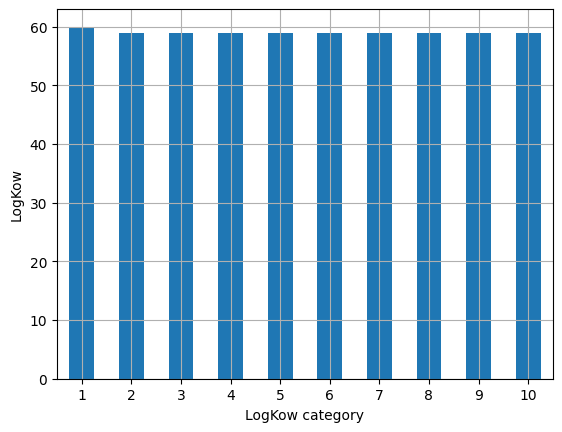

In [8]:
exploring_data['LogKow_categories'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("LogKow category")
plt.ylabel("LogKow")
plt.show()

In [9]:
exploring_data.head(10)

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_urea,MID_N,MID_O,MID_H,MID_X,apol,bpol,LogS,tR,LogKow_categories
0,11.799684,0.298750,-0.702503,0.809002,10.687500,256.132,245.044,255.021769,84,0.252049,...,0,1.958360,1.764103,7.240585,3.518122,33.636723,13.493277,-4.085698,6.956,6
1,11.683982,0.242803,-0.243241,0.787268,11.375000,236.702,223.598,236.071641,84,0.322078,...,1,4.080092,1.755851,7.594280,1.758337,33.890309,16.699691,-2.657603,6.277,5
2,12.459903,0.003848,-0.437868,0.453578,29.090909,300.398,276.206,300.172545,118,0.310237,...,0,0.000000,5.565769,5.565769,0.000000,50.139032,27.548968,-3.446334,8.273,7
3,12.243448,0.062819,-0.516986,0.334306,25.173913,318.373,296.197,318.157957,124,0.330315,...,1,4.378137,7.328871,11.707008,0.000000,48.467446,29.830554,-1.719092,7.090,2
4,13.616011,0.112135,-0.818986,0.588722,11.250000,349.745,336.641,349.051714,124,0.347491,...,0,2.024411,7.783294,13.338430,3.530726,44.103309,21.880691,-4.583445,7.564,7
5,12.018632,0.043401,-0.641623,0.802759,11.272727,341.194,327.082,340.038148,116,0.441527,...,0,4.277245,5.792214,13.625106,3.555647,43.351102,21.114898,-4.799513,7.924,7
6,12.618979,0.024833,-0.807971,0.608597,11.034483,411.885,389.709,411.123736,150,0.253332,...,0,2.012204,7.699383,11.472884,1.761297,59.567446,29.226554,-5.824763,6.768,6
7,13.517073,0.022773,-0.455218,0.739996,23.413793,394.423,372.247,394.141638,150,0.177566,...,0,0.000000,11.900204,11.900204,0.000000,57.891446,31.618554,-5.396232,7.545,7
8,5.619477,0.647691,0.647691,0.674825,9.583333,223.794,209.682,223.025619,70,0.136206,...,0,2.091804,0.000000,7.483466,1.689259,31.775102,19.954898,-2.537926,7.861,6
9,12.480061,0.057012,-0.390090,0.569227,29.318182,302.414,276.206,302.188195,120,0.310237,...,0,0.000000,5.565769,5.565769,0.000000,51.472618,29.555382,-3.808695,9.492,8


In [10]:
# Split the dataset into a stratified 80/20 partition (80% training and validation, 20% test)
data_train, data_test = train_test_split(
    exploring_data, 
    test_size=0.2,
    stratify=exploring_data['LogKow_categories'],
    random_state=25,
    shuffle=True
)

In [11]:
data_train_stratCategories=data_train['LogKow_categories'].copy()
data_train.drop('LogKow_categories', axis=1, inplace=True)
X_train=data_train.copy().drop(columns=['tR'])
y_train=data_train['tR'].copy()
train_idxs=X_train.index.to_list()

# Building feature preprocessing functions

## Defining feature transformers

In [12]:
power_transformation=PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
countFeatures=[feature for feature in list(X_train.columns) if feature.find("fr_")==0]+[feature for feature in list(X_train.columns) if feature.find("Num")>=0]+[feature for feature in list(X_train.columns) if feature.find("Coun")>=0]
realFeatures=list(set(X_train.columns)-set(countFeatures))

In [13]:
realNumerical_transformation_pipeline=Pipeline([
        ('imputer',SimpleImputer(strategy="median")),
        ("PowerTransform",power_transformation)
    ])

integerNumerical_transformation_pipeline=Pipeline([
        ('imputer',SimpleImputer(strategy="constant",fill_value=0)),
        #("standardTransform",StandardScaler())
        ("PowerTransform",power_transformation)
    ])

In [14]:
preprocessing = ColumnTransformer([
    ("realStandarization",realNumerical_transformation_pipeline,realFeatures),
    ("integerStandarization",integerNumerical_transformation_pipeline,countFeatures)
],remainder='passthrough')

In [15]:
X_train_preprocesed=preprocessing.fit_transform(X_train)
X_train_preprocesed_df = pd.DataFrame(X_train_preprocesed, 
                                      columns=[featureName.split("__")[1] for featureName in preprocessing.get_feature_names_out()],
                                      index=train_idxs)
print(len(X_train_preprocesed_df))
display(X_train_preprocesed_df.head(5))

472


,PEOE_VSA10,MinPartialCharge,SMR_VSA1,TPSA,PEOE_VSA3,SlogP_VSA5,VSA_EState2,SlogP_VSA1,PEOE_VSA1,apol,...,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,HeavyAtomCount,NHOHCount,NOCount,RingCount
174,-1.202513,0.698633,-2.039914,-0.145057,-1.321047,0.174041,0.135627,0.740175,0.284471,-0.883675,...,0.472817,-0.228478,0.209216,-0.332548,-0.312529,-0.444934,-1.067140,0.431265,0.172580,-0.686791
541,1.436505,-0.344236,2.104017,0.307507,1.422825,-0.536378,0.918939,1.319698,0.261779,0.538007,...,1.226231,1.999329,0.209216,-0.332548,-0.312529,-0.444934,1.530299,1.152372,0.172580,0.281641
123,0.261338,-0.155427,-0.411038,-0.216033,0.067296,1.309433,-0.081534,-0.087656,-0.657068,1.143587,...,-1.092066,-0.228478,1.615309,-0.332548,-0.312529,-0.444934,0.788794,-1.088591,-0.341177,0.281641
173,0.150704,0.600945,-0.995542,0.598673,0.098941,1.100396,0.475004,0.792214,0.341467,0.366701,...,1.226231,0.121578,0.591242,-0.332548,-0.312529,-0.444934,0.206588,1.152372,0.172580,0.281641
69,1.132463,-1.150338,1.273307,0.343936,0.725863,-0.368401,0.124727,0.644557,0.821376,-0.048329,...,0.472817,0.714874,0.209216,-0.332548,-0.312529,-0.444934,0.656984,0.431265,0.172580,0.281641


## Feature dimensionality reduction

67 PCs explaining 95.2% of the total variance


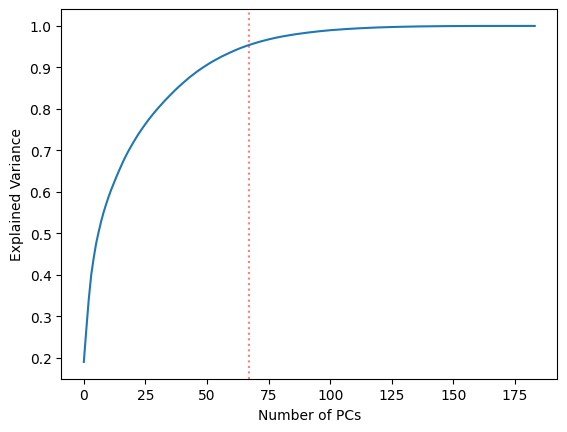

In [16]:
pca = PCA()
X_20D=pca.fit_transform(X_train_preprocesed_df)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
plt.plot(cumsum)
plt.axvline(x=d,color='red',linestyle = ':', alpha = 0.5,linewidth=1.5)
plt.xlabel(r"Number of PCs")
plt.ylabel(r"Explained Variance")
print(f"{d} PCs explaining {round(pca.explained_variance_ratio_[0:d].sum()*100,1)}% of the total variance")

In [17]:
pcaTransform = PCA(n_components=0.95)
X_pcaTranformed=pcaTransform.fit_transform(X_train_preprocesed)

In [18]:
# Save preprocessing transformers for model deployment
joblib.dump(preprocessing, os.path.join(MLModelsPath,"RT_M67vDIA_columnsTransformers.vd.joblib"))
joblib.dump(pcaTransform, os.path.join(MLModelsPath,"RT_M67vDIA_pcaTransformer.vd.joblib"))

['./models/retentionTime/RT_M67vDIA_pcaTransformer.vd.joblib']

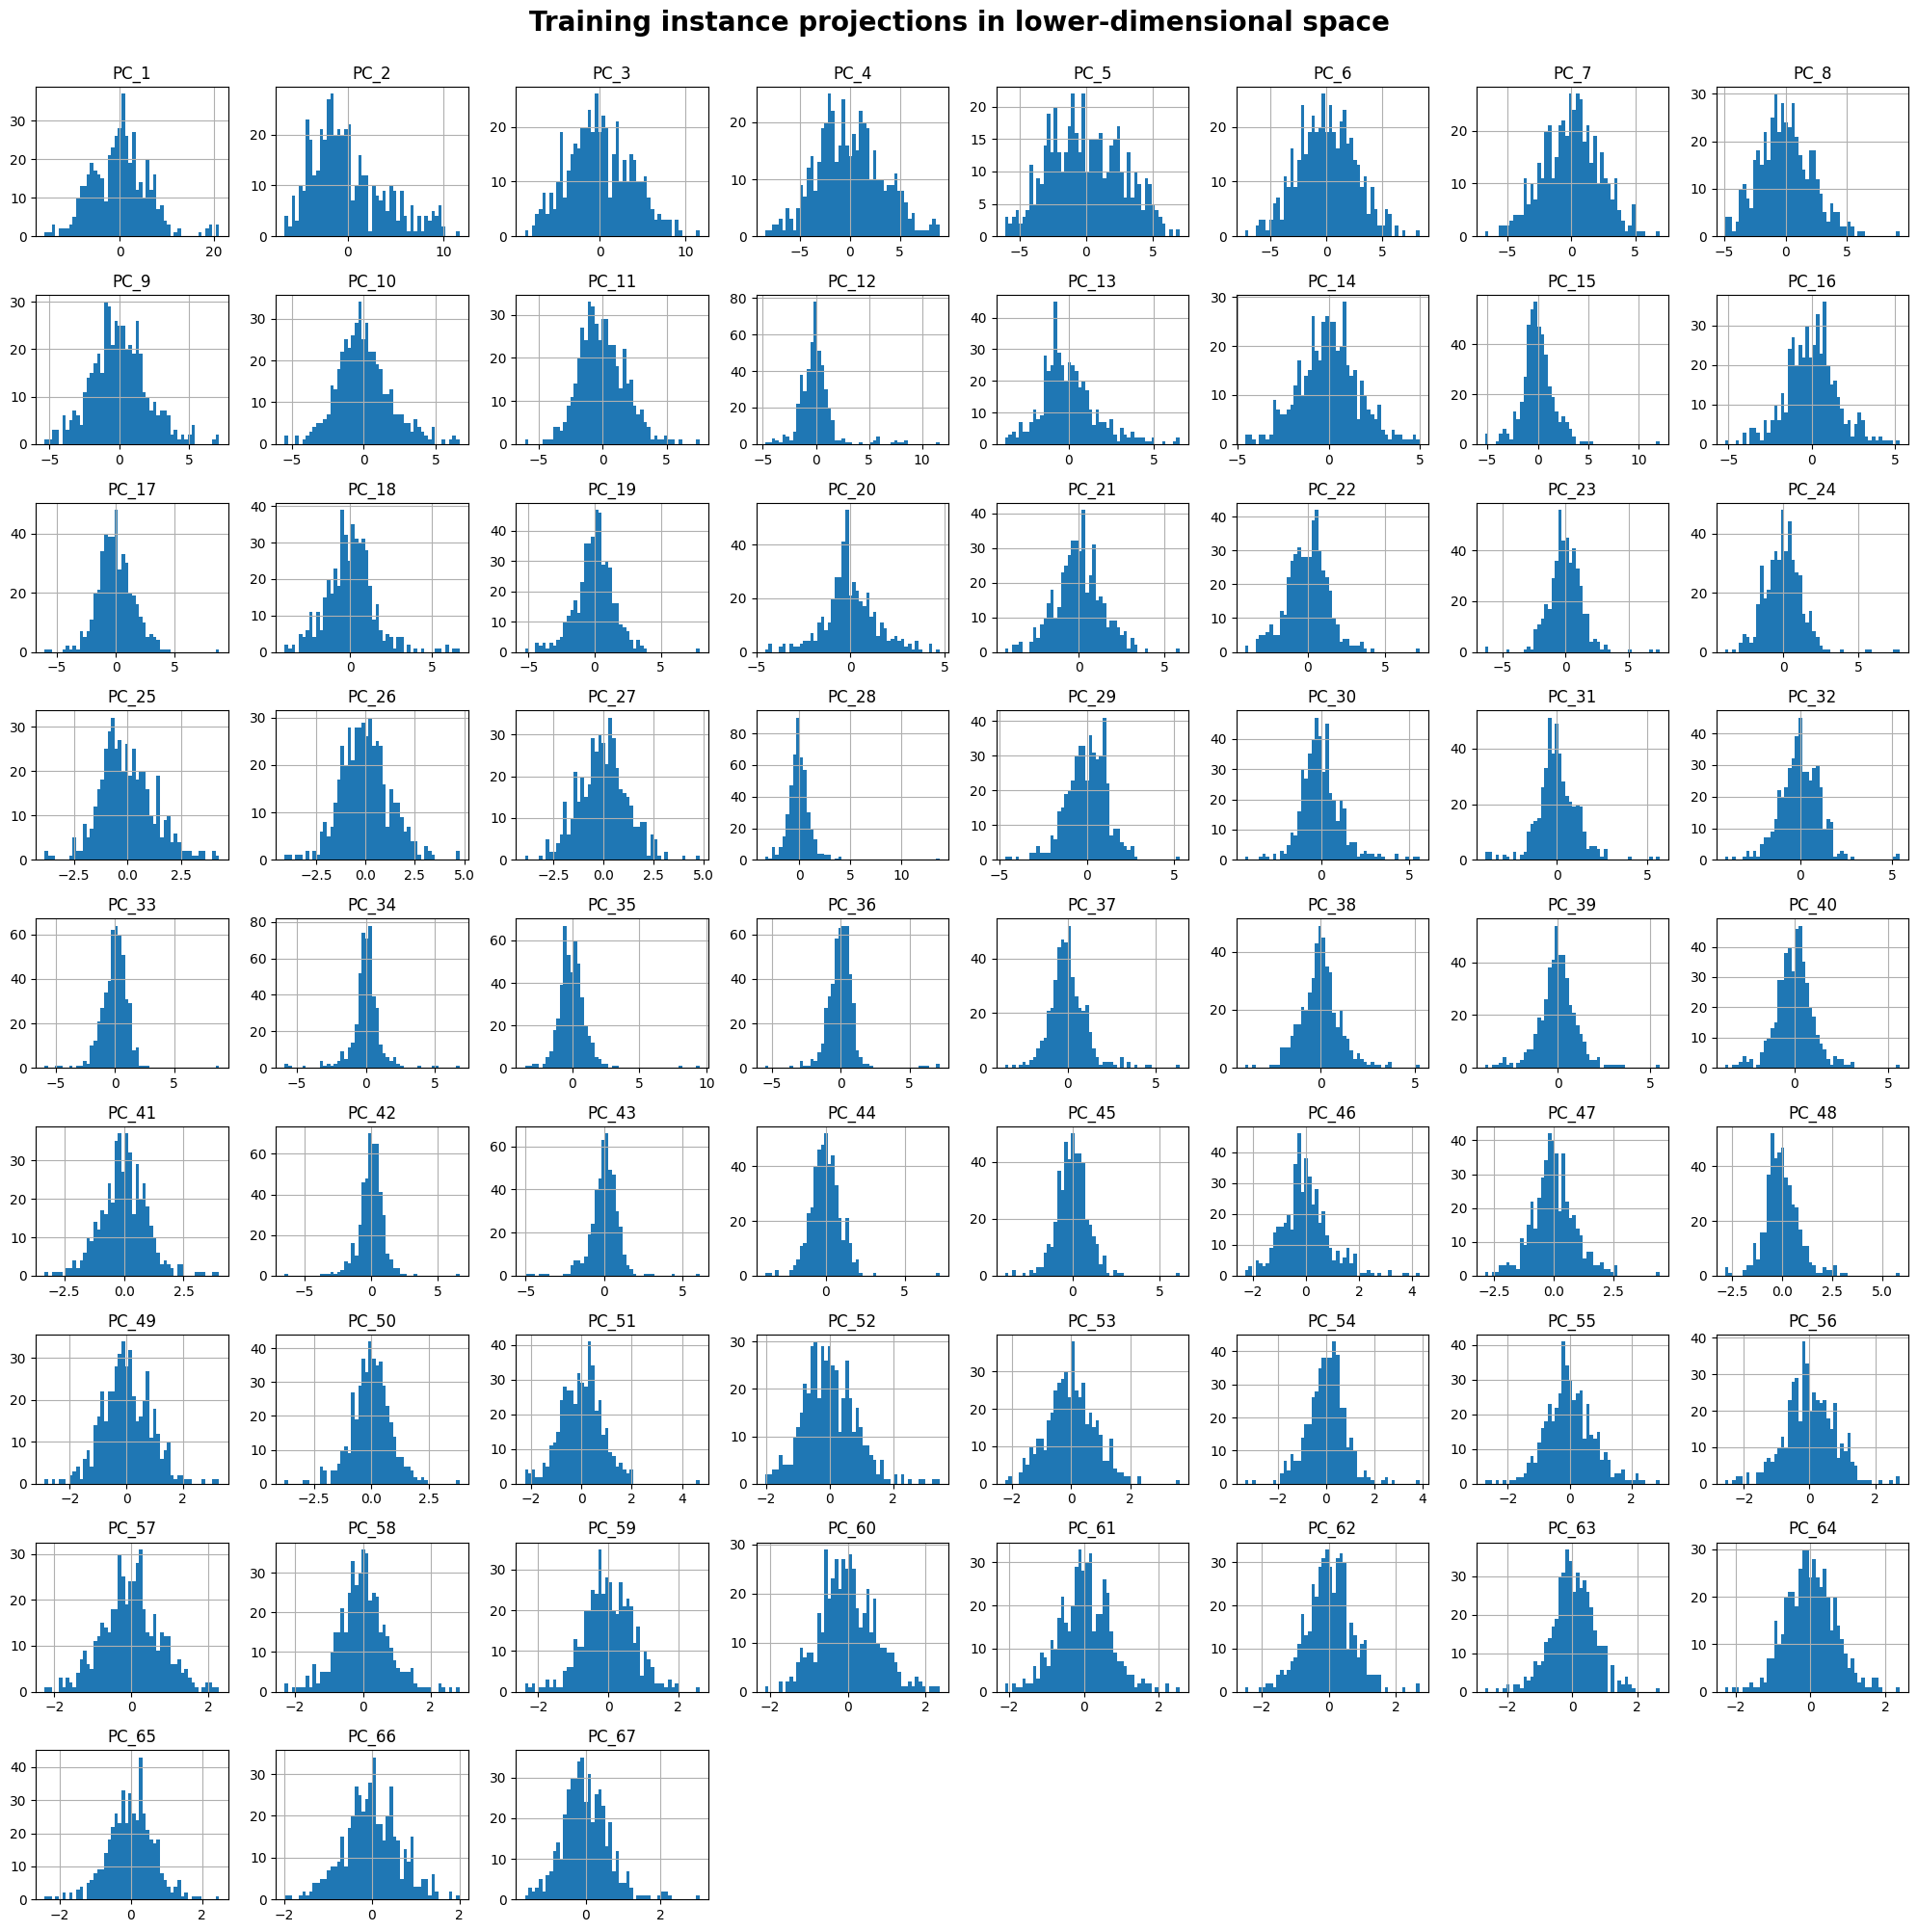

In [19]:
trainigDataFullTransformed=pd.DataFrame(X_pcaTranformed,columns=["PC_"+str(i+1) for i in range(0,np.shape(X_pcaTranformed)[1])])
trainigDataFullTransformed_names=list(trainigDataFullTransformed.columns)
plt_transf=trainigDataFullTransformed.hist(bins=50,figsize=(20,20))
plt.suptitle(r"Training instance projections in lower-dimensional space",fontweight='bold',size=20,y=1.0)
plt.tight_layout() 
plt.show()

# **XGBRegressor Hyperparameter Optimization and Model Fitting**

In [20]:
X_train_transformed=X_pcaTranformed
y_train_=y_train.copy().to_numpy()
print(len(X_train_transformed),len(y_train_))

472 472


In [21]:
# XGBRegressor hyperparameter optimization by bayessian optimization


isHyperparameterOpt=False
  
if isHyperparameterOpt:
    
    ntrials=5000
    startTime = time.monotonic()
    parameters_space={'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
                      'learning_rate':hp.uniform('learning_rate',0.05,0.1),
                      'max_depth':hp.quniform('max_depth',3,10,1),
                      'min_child_weight' : hp.quniform('min_child_weight', 4, 10, 1),
                      'n_estimators':hp.quniform('n_estimators',1000,1300,1),
                      'subsample' : hp.uniform('subsample', 0.5,1),
                      'gamma': hp.uniform ('gamma', 1,8),
                      'reg_lambda' : hp.uniform('reg_lambda', 0,1)
                     }
    cv=rTools.kFoldsRegressorSplitWithStratification(range(0,len(y_train_)),data_train_stratCategories,k_folds=ntrials)
    def hyperparameter_opt(pspace):
        clear_output(wait=True)
        RT_XGB_regressor=XGBRegressor(n_jobs=6,
                                      random_state=42,
                                      colsample_bytree=pspace['colsample_bytree'],
                                      learning_rate=pspace['learning_rate'],
                                      max_depth=int(pspace['max_depth']),
                                      min_child_weight=int(pspace['min_child_weight']),
                                      n_estimators=int(pspace['n_estimators']),
                                      subsample=pspace['subsample'],
                                      gamma=pspace['gamma'],
                                      reg_lambda=int(pspace['reg_lambda']),
                                      eval_metric="rmse",
                                      early_stopping_rounds=10
                                     )
        kf=next(cv)
        x_train_opt=X_train_transformed[kf[0]]
        y_train_opt=y_train_[kf[0]]
        x_test_opt=X_train_transformed[kf[1]]
        y_test_opt=y_train_[kf[1]]

        evaluation = [( x_train_opt, y_train_opt), ( x_test_opt, y_test_opt)]
        RT_XGB_regressor.fit(x_train_opt, 
                             y_train_opt,
                             eval_set=evaluation,verbose=0)
        
        y_pred = RT_XGB_regressor.predict(x_test_opt)
        mse= mean_squared_error(y_test_opt, y_pred)
        print(f"MSE: {mse}")

        return {'loss':mse, 'status': STATUS_OK, 'model': RT_XGB_regressor}


    trials = Trials()
    best_params_ = fmin(fn=hyperparameter_opt,
            space=parameters_space,
            algo=tpe.suggest,
            max_evals=ntrials,
            trials=trials,
            show_progressbar=True
            )
    
    elapsed_time = time.monotonic() - startTime
    print(f"Bayesian search elapsed time: {round(elapsed_time,2)} s")
    print(f"Best parameters: {best_params_}\n")
    pd.DataFrame(trials.results).to_csv(os.path.join(modelEvalPath,"hp_searchResults_RT_model_XGBRegressor.vd.tsv"),sep="\t",index_label="iter")
    pd.DataFrame.from_dict(best_params_, orient='index').to_csv(os.path.join(modelEvalPath,"hp_optimalParameters_RT_model_XGBRegressor.vd.tsv"),sep="\t",index=True)

    #The optimal hyperparameters obtained through bayessian optimization are:
    __best_colsample_bytree=best_params_['colsample_bytree']
    __best_learning_rate=best_params_['learning_rate']
    __best_max_depth=best_params_['max_depth']
    __best_min_child_weight=best_params_['min_child_weight']
    __best_n_estimators=best_params_['n_estimators']
    __best_subsample=best_params_['subsample']
    __best_gamma=best_params_['gamma']
    __best_reg_lambda=best_params_['reg_lambda']


else:
    #Bayesian search elapsed time: 1434.76 s
    #Best parameters: {'colsample_bytree': 0.9788935146383471 , 'gamma': 1.5757170698954277, 'learning_rate':0.08711534374630635, 
    #                  'max_depth': 3.0, 'min_child_weight': 4.0, 'n_estimators': 1271.0, 
    #                  'reg_lambda': 0.9899379442234242, 'subsample': 0.5828959534186824}

    __best_colsample_bytree=0.9788935146383471
    __best_learning_rate=0.08711534374630635
    __best_max_depth=3
    __best_min_child_weight=4
    __best_n_estimators=1271
    __best_subsample=0.5828959534186824
    __best_gamma=1.575717069895427
    __best_reg_lambda=0.9899379442234242




## **Model fitting using optimal hyperparameters**

In [22]:

RT_XGB_regressor=XGBRegressor(colsample_bytree=__best_colsample_bytree,
                              learning_rate=__best_learning_rate,
                              max_depth=int(__best_max_depth),
                              min_child_weight=int(__best_min_child_weight),
                              n_estimators=int(__best_n_estimators),
                              subsample=__best_subsample,
                              gamma=__best_gamma,
                              reg_lambda=__best_reg_lambda,
                              n_jobs=6,
                              random_state=42)
RT_XGB_regressor.fit(X_train_transformed,y_train_)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9788935146383471, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1.575717069895427,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08711534374630635,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1271, n_jobs=6,
             num_parallel_tree=None, random_state=42, ...)

# **Model performance assessment**


## **Training Set Performance Assessment**

In [23]:
tR_predictions_train=RT_XGB_regressor.predict(X_train_transformed)
RTmodel_assessment_crossValidation=cross_validate(RT_XGB_regressor,
                                                  X_train_transformed,
                                                  y_train_,
                                                  scoring=["neg_mean_squared_error",
                                                           "neg_root_mean_squared_error",
                                                           "r2",
                                                           "neg_mean_absolute_error"
                                                          ],
                                                  cv=10
                                                 )


In [24]:
print("Cross-validation Performance Assessment")
maeData=np.abs(RTmodel_assessment_crossValidation['test_neg_mean_absolute_error'])
UmaeData=maeData.std()/np.sqrt(len(maeData))*stats.t.interval(0.95,len(maeData)-1)[1]
rmseData=np.abs(RTmodel_assessment_crossValidation['test_neg_root_mean_squared_error'])
UrmseData=rmseData.std()/np.sqrt(len(rmseData))*stats.t.interval(0.95,len(rmseData)-1)[1]
r2Data=RTmodel_assessment_crossValidation['test_r2']
Ur2Data=r2Data.std()/np.sqrt(len(r2Data))*stats.t.interval(0.95,len(r2Data)-1)[1]
cvTrainResults=pd.DataFrame({"Score":["MAE","RMSE","R2"],
             "mean":[maeData.mean(),rmseData.mean(),r2Data.mean()],
             "std":[maeData.std(),rmseData.std(),r2Data.std()],
             "U.95":[UmaeData,UrmseData,Ur2Data]})
cvTrainResults.to_csv(os.path.join(modelEvalPath,"crossValidationResults_RT_model_XGBRegressor.vd.tsv"),sep="\t",index=False)
cvTrainResults

Cross-validation Performance Assessment


,Score,mean,std,U.95
0,MAE,0.748983,0.150906,0.107952
1,RMSE,0.977970,0.195989,0.140202
2,R2,0.665885,0.086392,0.061801


### Analysis of the training residuals

In [25]:
trainSet_results=pd.DataFrame({"tR_prediction":tR_predictions_train,"tR_target":y_train,"dtR":tR_predictions_train-y_train})
trainSet_results.to_csv(os.path.join(modelEvalPath,"trainingResiduals_RT_model_XGBRegressor.vd.tsv"),sep="\t",index=False)

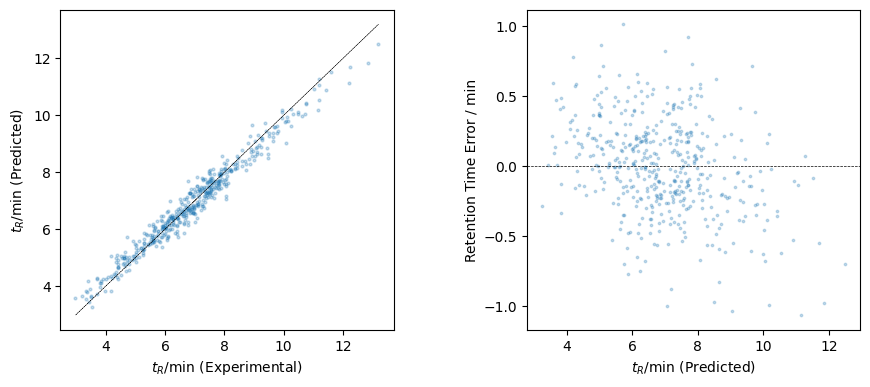

In [26]:
fig,axs=plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs[0].plot(trainSet_results.tR_target,trainSet_results.tR_target,c="black", linewidth=0.3, linestyle='--')
axs[0].scatter(trainSet_results.tR_target,trainSet_results.tR_prediction,alpha=0.25,s=4)
axs[0].set_xlabel(r'$t_R$/min (Experimental)' )
axs[0].set_ylabel(r'$t_R$/min (Predicted)')
plt.subplots_adjust(wspace=0.4, hspace=0.6, left=0.1, right=0.9, top=0.9, bottom=0.1)
axs[1].scatter(trainSet_results.tR_prediction,trainSet_results.dtR,alpha=0.25,s=3)
axs[1].axhline(y=0,color='black', linestyle='--', linewidth=0.5)
axs[1].set_xlabel(r'$t_R$/min (Predicted)')
axs[1].set_ylabel('Retention Time Error / min')
plt.show()

## **Test-set performance assessment**

In [27]:
X_test=data_test.copy().drop(columns=['tR','LogKow_categories'])
y_test_=data_test['tR'].copy().to_numpy()
y_test_strat=data_test['LogKow_categories'].copy().to_numpy()
test_idxs=X_test.index.to_list()
X_test_transformed=pcaTransform.transform(preprocessing.transform(X_test))

In [28]:
len(X_train_transformed[0])

67

In [29]:

cvTestResults=rTools.getTestRegressorMetricsStatistics(RT_XGB_regressor,
                                                         X_test_transformed,
                                                         y_test_,
                                                         y_test_strat,n_folds=10)
cvTestResults.to_csv(os.path.join(modelEvalPath,"testSetResults_RT_model_XGBRegressor.vd.tsv"),sep="\t",index=False)
cvTestResults

,score,mean,std,U.95,n,data
0,MAE,0.717615,0.054848,0.039236,10,"[0.6556310310363771, 0.7787604043324788, 0.665..."
1,RMSE,0.949284,0.085275,0.061002,10,"[0.8396654765380812, 1.052690957545162, 0.8656..."
2,R2,0.715342,0.026571,0.019008,10,"[0.7451424456379083, 0.6909677328875359, 0.739..."


In [30]:
tR_predictions_test=RT_XGB_regressor.predict(X_test_transformed)
testSet_results=pd.DataFrame({"tR_prediction":tR_predictions_test,"tR_target":y_test_,"dtR":tR_predictions_test-y_test_})
testSet_results['instanceIdx']=test_idxs
testSet_results.to_csv(os.path.join(modelEvalPath,"testResiduals_RT_model_XGBRegressor.vd.tsv"),sep="\t",index=False)
testSetInstances=data['instances_info'].iloc[test_idxs].copy()
testSetInstances=testSetInstances.join(testSet_results.set_index("instanceIdx",drop=False)).reset_index(drop=True)
testSetInstances.to_csv(os.path.join(modelEvalPath,"testSetInstances_RT_model_XGBRegressor.vd.tsv"),sep="\t",index=False)

In [31]:
test_errors_cum=pd.DataFrame()
for tR_err in np.linspace(0.1,5,endpoint=True):
    lims=Counter(abs(tR_predictions_test-y_test_)>tR_err)
    test_errors_cum=pd.concat([test_errors_cum,pd.DataFrame({'tR_error':[tR_err],
                                                             'p':[lims[False]/(lims[False]+lims[True])]
                                                            })],sort=False,ignore_index=True)
display(test_errors_cum[0:16])

,tR_error,p
0,0.1,0.092437
1,0.2,0.210084
2,0.3,0.285714
3,0.4,0.369748
4,0.5,0.478992
5,0.6,0.554622
6,0.7,0.621849
7,0.8,0.663866
8,0.9,0.689076
9,1.0,0.731092


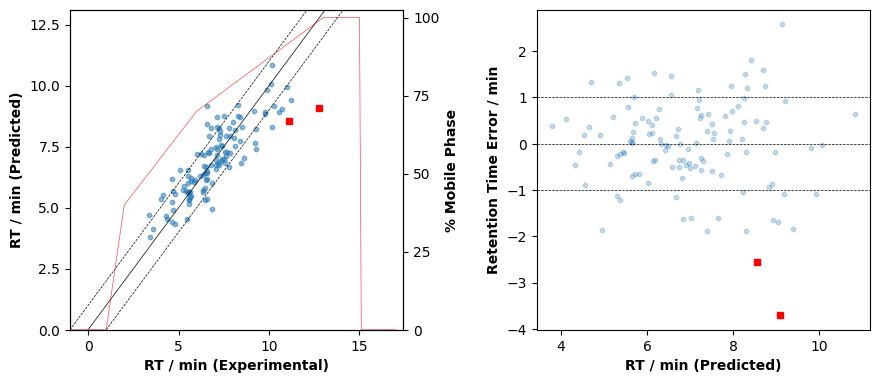

In [32]:
eg=data['elution_gradient']
fig,axs=plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs[0].scatter(testSet_results.tR_target,testSet_results.tR_prediction,alpha=0.5,s=10)
axs[0].set_xlim(min(eg.time), max(max(testSet_results.tR_prediction),max(testSet_results.tR_target),max(eg.time) )*1.025)
axs[0].set_ylim(0, max(max(testSet_results.tR_prediction),max(testSet_results.tR_target))*1.025)
axs[0].axline((0, 0), slope=1, color='black', linestyle='-',linewidth=0.5)
axs[0].axline((0, 1), slope=1, color='black', linestyle='--',linewidth=0.5)
axs[0].axline((0, -1), slope=1, color='black', linestyle='--',linewidth=0.5)
axs[0].set_xlabel(r'RT / min (Experimental)',fontweight='bold')
axs[0].set_ylabel(r'RT / min (Predicted)',fontweight='bold')

ProquinazidData=testSetInstances[testSetInstances.name=="Proquinazid"]
DodemorphData=testSetInstances[testSetInstances.name=="Dodemorph"]
axs[0].plot([ProquinazidData.tR_target], [ProquinazidData.tR_prediction], marker='s', color='red', markersize=5)
axs[0].plot([DodemorphData.tR_target], [DodemorphData.tR_prediction], marker='s', color='red', markersize=5)
axs[0].set_xticks(list(np.arange(0.0,17,5)))
axs[0].set_yticks(list(np.arange(0.0,13,2.5)))

ax2 = axs[0].twinx()
ax2.set_ylim(0, max(eg.B)*1.025)
ax2.plot('time',"B",data=eg,color='red',alpha=0.7,linewidth=0.5)
ax2.set_ylabel(r'% Mobile Phase',fontweight='bold')
ax2.set_yticks(list(np.arange(0.0,101,25)))
plt.subplots_adjust(wspace=0.4, hspace=0.6, left=0.1, right=0.9, top=0.9, bottom=0.1)
axs[1].scatter(testSet_results.tR_prediction,testSet_results.dtR,alpha=0.25,s=10)
axs[1].axhline(y=0,color='black', linestyle='--', linewidth=0.5)
axs[1].axhline(y=1,color='black', linestyle='--', linewidth=0.5)
axs[1].axhline(y=-1,color='black', linestyle='--', linewidth=0.5)
axs[1].set_xlabel(r'RT / min (Predicted)',fontweight='bold')
axs[1].set_ylabel('Retention Time Error / min',fontweight='bold')
axs[1].plot([ProquinazidData.tR_prediction], [ProquinazidData.dtR], marker='s', color='red', markersize=5)
axs[1].plot([DodemorphData.tR_prediction], [DodemorphData.dtR], marker='s', color='red', markersize=5)
plt.show()

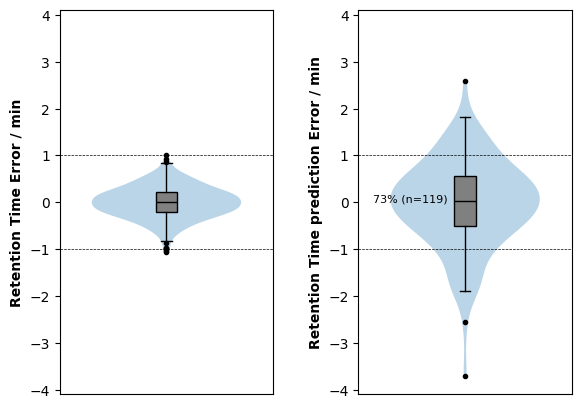

In [33]:
fig = plt.figure()
gs = fig.add_gridspec(1,2, hspace=0)
axs = gs.subplots(sharey=False)

flier_properties = dict(markerfacecolor='black', marker='o', markersize=3,
                        linestyle='none')

axs[0].violinplot(trainSet_results.dtR, widths=0.7,
                     showmeans=False, showextrema=False, showmedians=False,bw_method=0.4)
axs[0].set_ylabel('Retention Time Error / min',fontweight='bold')
boxp=axs[0].boxplot(trainSet_results.dtR, flierprops=flier_properties,patch_artist=True,widths=0.1)
axs[0].set_xticks([])
axs[0].set_ylim(-4.1,4.1)
boxp['boxes'][0].set_facecolor('gray')
boxp['medians'][0].set_color('black')
axs[0].axhline(y=-1,color='black', linestyle='--', linewidth=0.5)
axs[0].axhline(y=1,color='black', linestyle='--', linewidth=0.5)


plt.subplots_adjust(wspace=0.4, hspace=0.6, left=0.1, right=0.9, top=0.9, bottom=0.1)
axs[1].violinplot(testSet_results.dtR, widths=0.7,
                     showmeans=False, showextrema=False, showmedians=False,bw_method=0.4)

boxp=axs[1].boxplot(testSet_results.dtR, flierprops=flier_properties,patch_artist=True,widths=0.1)
boxp['boxes'][0].set_facecolor('gray')
boxp['medians'][0].set_color('black')
axs[1].axhline(y=-1,color='black', linestyle='--', linewidth=0.5)
axs[1].axhline(y=1,color='black', linestyle='--', linewidth=0.5)
axs[1].set_ylabel('Retention Time prediction Error / min',fontweight='bold')
dfrac=len(testSet_results[abs(testSet_results.dtR)<=1.0])/len(testSet_results)*100
axs[1].text(0.57, 0.0, f"{round(dfrac)}% (n={len(testSet_results)})", fontsize=8, color='black')
axs[1].set_xticks([])
axs[1].set_yticks(list(np.arange(-4,4.1,1)))
axs[1].set_ylim(-4.1,4.1)
plt.show()

# **Final model fitting using all training data**

In [34]:
X_allData=exploring_data.copy().drop(columns=['tR','LogKow_categories'])
y_allData=exploring_data['tR'].copy().to_numpy()
X_allData_transformed=pcaTransform.transform(preprocessing.transform(X_allData))
RT_XGB_regressor_final=XGBRegressor(colsample_bytree=__best_colsample_bytree,
                              learning_rate=__best_learning_rate,
                              max_depth=int(__best_max_depth),
                              min_child_weight=int(__best_min_child_weight),
                              n_estimators=int(__best_n_estimators),
                              subsample=__best_subsample,
                              gamma=__best_gamma,
                              reg_lambda=__best_reg_lambda,
                              n_jobs=6,
                              random_state=42)
RT_XGB_regressor_final.fit(X_allData_transformed,y_allData)
joblib.dump(RT_XGB_regressor_final, os.path.join(MLModelsPath,"RT_XGBRegressor_model_M67vDIA.vd.joblib"))


['./models/retentionTime/RT_XGBRegressor_model_M67vDIA.vd.joblib']

# **Uncertainty Estimation of the Retention Time Model**

In [35]:

uFile=os.path.join(modelEvalPath,"uncertainty_RT_XGBRegressor_model_M67vDIA.vd.tsv")
data_idxs=exploring_data[['LogKow_categories']].copy().reset_index().rename(columns={'index':'idxs'})
X_cdata=pcaTransform.transform(preprocessing.transform(exploring_data.drop(columns=['tR','LogKow_categories'])))
Y_cdata=exploring_data['tR'].to_numpy()
RTmodel_ci=rTools.getRTModelConfidenceInterval(uFile,X_cdata,Y_cdata,data_idxs,RT_XGB_regressor_final)
RTmodel_ci.to_csv(os.path.join(MLModelsPath,"ci_RT_XGBRegressor_model_M67vDIA.vd.tsv"),sep="\t",index=False)
RTmodel_ci

,tR_pred_mean,tR_pred_std,tR_exp_mean,tR_exp_std,n,RMSError,U.95,tR_lb,tR_ub,RMSE_model
0,3.369873,0.155547,3.53897,0.287936,13510,0.339181,0.664843,2.70503,4.034716,0.981451
1,3.57966,0.014221,3.642985,0.363763,3330,0.368930,0.723352,2.856308,4.303012,0.981451
2,3.62973,0.014479,3.688908,0.394969,4070,0.399287,0.782821,2.846909,4.412551,0.981451
3,3.679617,0.014437,3.706003,0.39909,4750,0.400219,0.784615,2.895001,4.464232,0.981451
4,3.72955,0.014351,3.721575,0.410301,5472,0.410309,0.804368,2.925182,4.533918,0.981451
...,...,...,...,...,...,...,...,...,...,...
135,10.703654,0.222592,10.390956,1.397824,20088,1.486059,2.912798,7.790856,13.616452,0.981451
136,10.277826,0.014464,10.399212,1.308992,4746,1.314602,2.577231,7.700595,12.855056,0.981451
137,10.328161,0.014527,10.408818,1.307355,4202,1.309950,2.568196,7.759965,12.896357,0.981451
138,10.377964,0.01448,10.430206,1.320813,3839,1.321500,2.590909,7.787055,12.968873,0.981451
